# **Importing Libraries**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
import re
from sklearn.metrics import classification_report, confusion_matrix  
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from stringkernels.kernels import string_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khadidjabourega/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing Datasets**

In [2]:
test_PATH = "data/test_data.csv"
train_result_PATH ="data/train_results.csv"
train_PATH = "data/train_data.csv"

In [3]:
test = pd.read_csv(test_PATH)
train_result = pd.read_csv(train_result_PATH)
train = pd.read_csv(train_PATH)

# Data overview : 

In [4]:
# preview the data
train

,id,text
0,0,Anyway Im getting of for a while
1,1,"My red, Apache isn't feelin too well this morn..."
2,2,@danyelljoy you should be its great. friday w...
3,3,its 11:30pm and i dont wanna sleep; so i debat...
4,4,Why does twitter eat my DM's? Not happy
...,...,...
1040318,1040318,getting ready 2 watch mental
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...


In [5]:
train.shape

(1040323, 2)

In [6]:
test.shape

(560175, 2)

Text(0.5, 1.0, 'Sentiment Data Distribution')

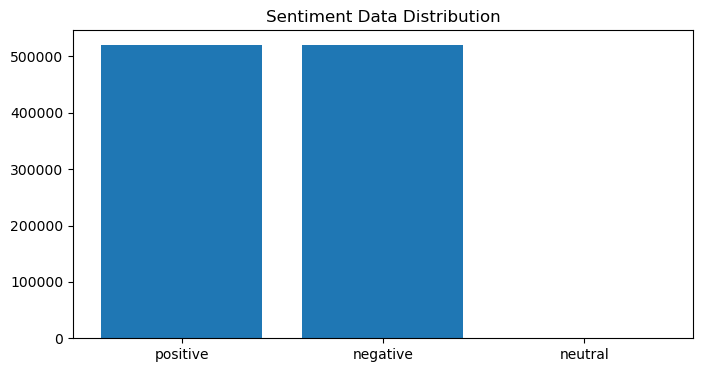

In [7]:
val_count = train_result['target'].value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [8]:
train_result['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

# Preprocessing:

In this section we will prepare the dataset in order to use in SVM model.

We will clean all website links, and all unrelevant digits.... 

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

 We'll split texts into their words and remove words that have no special meaning ( stopwords)

In [10]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
train.text = train.text.apply(lambda x: preprocess(x))
test.text = test.text.apply(lambda x: preprocess(x))

convert labels into integers, we will label negatives as 0, neutrals as 1 and positives as 2.

In [12]:
train = train[['text']]
test = test[['text']]
train_result = train_result[['target']]
train_result['target'] = np.where(train_result['target']=='negative', 0,( np.where(train_result['target']=='neutral',1,2)))

In [13]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
df = pd.concat([train, train_result],axis=1)

In [18]:
df1, df2 =  train_test_split(df, test_size=0.05, stratify=df.target)

In [20]:
sentences_train, sentences_test, y_train, y_test = train_test_split(df2[['text']], df2[['target']], test_size=1-TRAIN_SIZE,
                                         random_state=49)

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 33923


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(sentences_train.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(sentences_test.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_testfinal = pad_sequences(tokenizer.texts_to_sequences(test.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

# SVM

Everything is ready, now ve can fit our classifier.

#### Grid Search

In [ ]:
param_grid = {'C': [0.1,1, 10, 100,1000], 'gamma': [1,0.1,0.01,.05,0.001, 0.0001]}

grid = GridSearchCV(svm.SVC(kernel=string_kernel()),param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)
print(grid.best_estimator_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


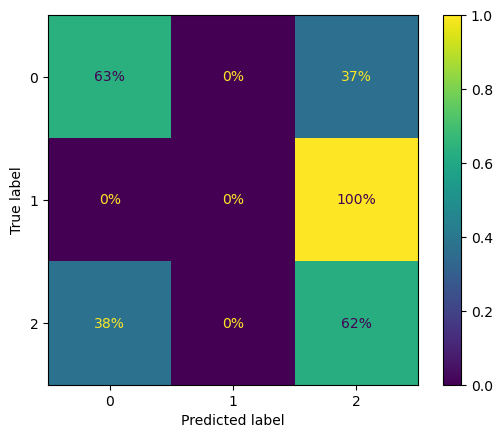

In [32]:
plot_confusion_matrix(grid, x_test, y_test, values_format= '.0%', normalize='true',cmap=plt.cm.Blues)

#### No hyperparameter tuning

In [24]:
svm_model = svm.SVC(kernel=string_kernel())
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_accuracy*100, 2)))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:734: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


Validation Accuracy: 62.99%


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


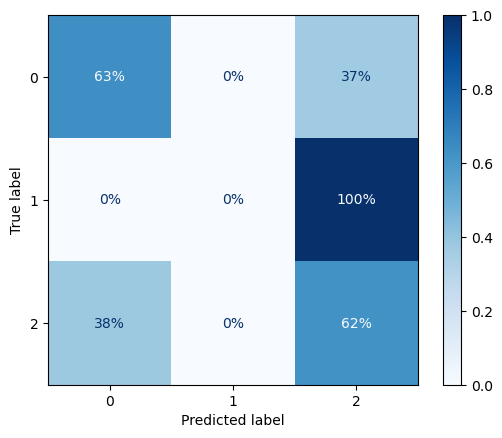

In [33]:
plot_confusion_matrix(svm_model, x_test, y_test, values_format= '.0%', normalize='true',cmap=plt.cm.Blues,)

# **Submit test predictions**

In [20]:
prediction=clf.predict(X_tf_idf_test) 
df = pd.DataFrame(prediction, columns = ['target'])
df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df.to_csv("svm.csv",index=False)